<font size=6><b> Setp01. EDA

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from pandas.plotting import scatter_matrix

# ----------------- 학습 ----------------------

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier


# ----------------- 평가 ----------------------
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve

# Data Load

In [3]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
submit = pd.read_csv("sample_submission.csv")

# ID

In [4]:
train['ID'].nunique(), train.shape

(30200, (30200, 14))

In [5]:
train = train.drop('ID', axis=1)
test  = test.drop('ID', axis=1)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30200 entries, 0 to 30199
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   가입일      30200 non-null  int64  
 1   음성사서함이용  30200 non-null  int64  
 2   주간통화시간   30200 non-null  float64
 3   주간통화횟수   30200 non-null  int64  
 4   주간통화요금   30200 non-null  float64
 5   저녁통화시간   30200 non-null  float64
 6   저녁통화횟수   30200 non-null  int64  
 7   저녁통화요금   30200 non-null  float64
 8   밤통화시간    30200 non-null  float64
 9   밤통화횟수    30200 non-null  int64  
 10  밤통화요금    30200 non-null  float64
 11  상담전화건수   30200 non-null  int64  
 12  전화해지여부   30200 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 3.0 MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12943 entries, 0 to 12942
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   가입일      12943 non-null  int64  
 1   음성사서함이용  12943 non-null  int64  
 2   주간통화시간   12943 non-null  float64
 3   주간통화횟수   12943 non-null  int64  
 4   주간통화요금   12943 non-null  float64
 5   저녁통화시간   12943 non-null  float64
 6   저녁통화횟수   12943 non-null  int64  
 7   저녁통화요금   12943 non-null  float64
 8   밤통화시간    12943 non-null  float64
 9   밤통화횟수    12943 non-null  int64  
 10  밤통화요금    12943 non-null  float64
 11  상담전화건수   12943 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 1.2 MB


In [8]:
train.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
0,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0
1,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0
2,93,28,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0
3,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0
4,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0


# target Feature
* <font color=red size=4><b> 불균형
* Churn rate(고객 이탈률)
    * 정해진 기간 내 이탈 고객을 전체 고객수로 나눈 수치

Churn rate 양성비율 : 10.986755
0    26882
1     3318
Name: 전화해지여부, dtype: int64


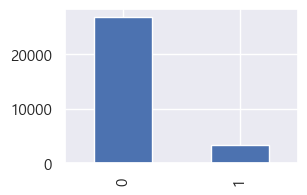

In [9]:
print( f"Churn rate 양성비율 : {len(train[train['전화해지여부']== 1]) / len(train) * 100 :2f}" )
print( train['전화해지여부'].value_counts() )
train['전화해지여부'].value_counts().plot(kind='bar', figsize=(3,2))
plt.show()



# 파생피쳐

## 가입일

In [10]:
train['가입일'].min(), train['가입일'].max()

(1, 2212)

* $ 지수화 = \frac {가입일} {가입일-시작일} * 100 $

In [11]:
traincp = train.copy()

In [12]:
# train['가입일지수'] = train['가입일'].apply(lambda d :  (d / (2213 -d )) * 100 )
train['가입기간년'] = train['가입일'] // 365
train['가입기간월'] = np.floor(train['가입일'] // 12)
train['가입기간주'] = np.floor(train['가입일'] // 52)
train['가입월']     = np.floor(train['가입일'] / 30) - (  ( np.floor(train['가입일'] / 30) / 12).astype(int) * 12  )  

test['가입기간년']  = test['가입일'] // 365
test['가입기간월']  = np.floor(test['가입일'] // 12)
test['가입기간주']  = np.floor(test['가입일'] // 52)
test['가입월']      = np.floor(test['가입일'] / 30) - (  ( np.floor(test['가입일'] / 30) / 12).astype(int) * 12  )  

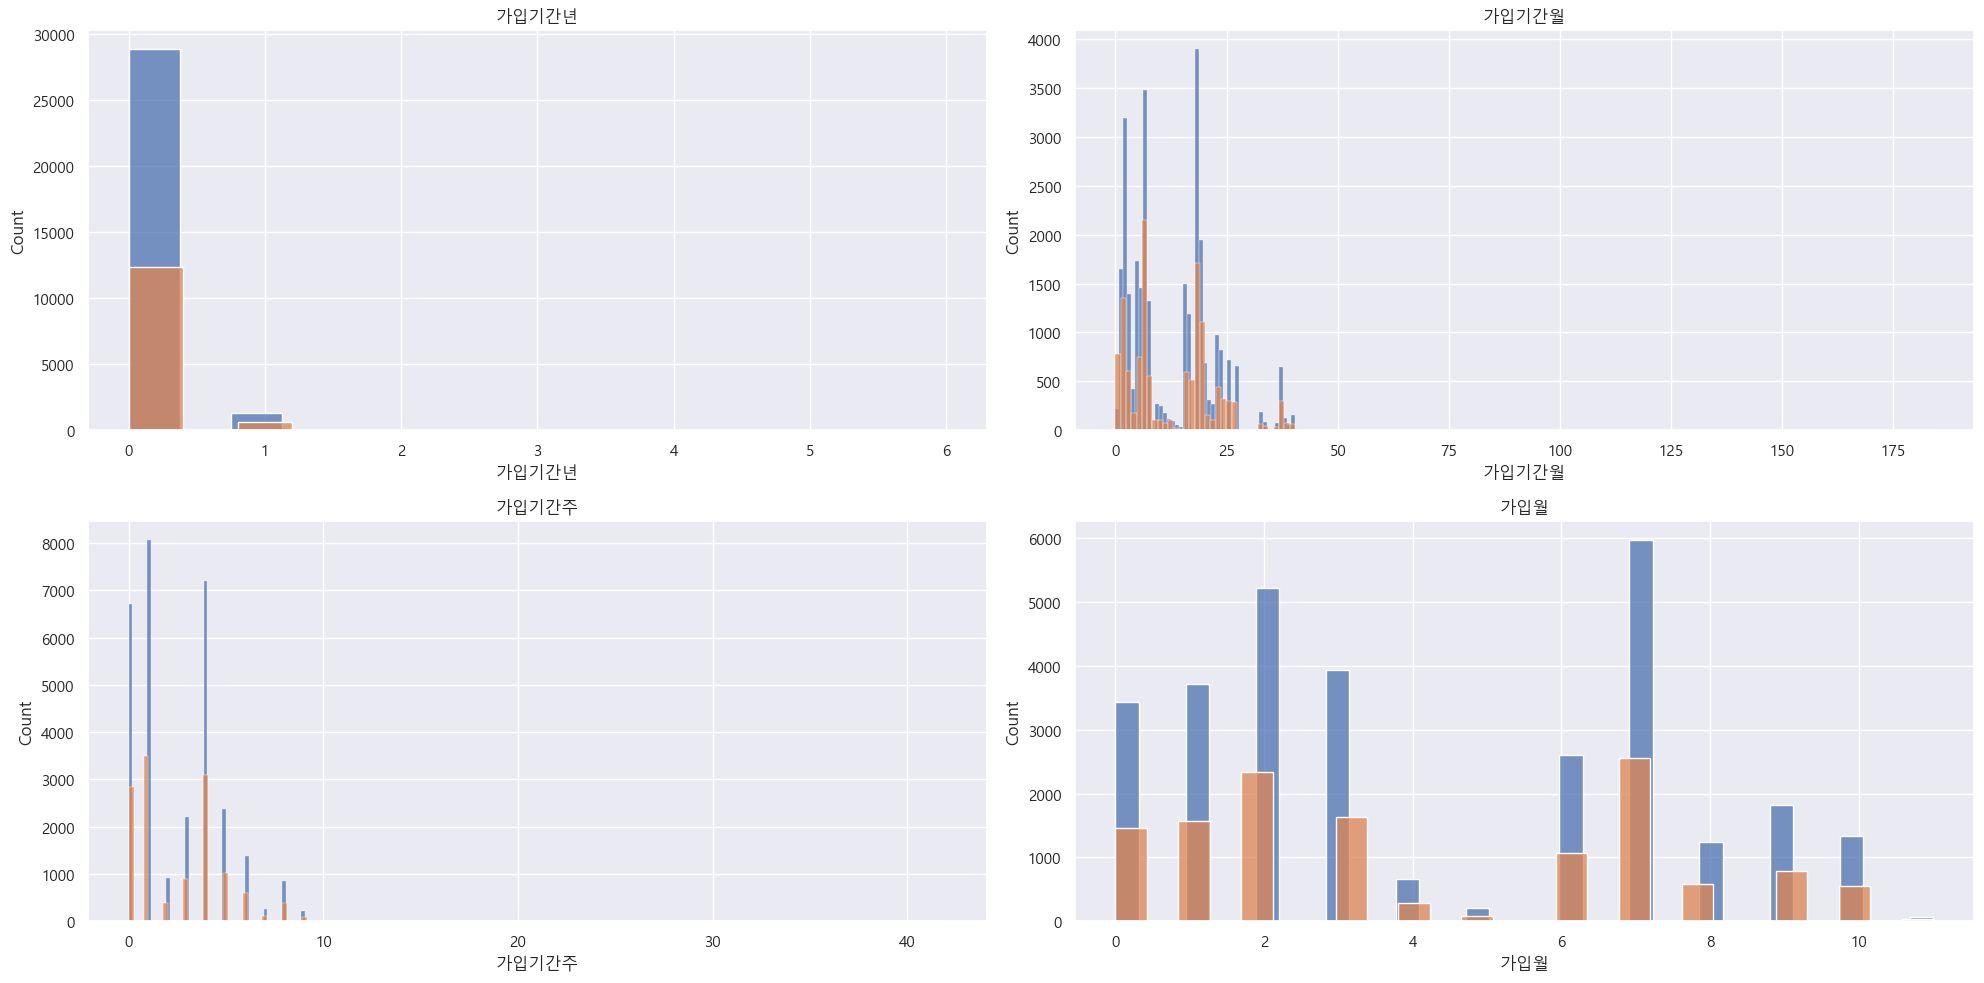

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10)  ) 

for i, col in enumerate(['가입기간년','가입기간월','가입기간주','가입월']) :
    r = i//2
    c = i%2
    axes[r][c].set_title(col)
    sns.histplot(data=train, x=col, ax=axes[r][c])
    sns.histplot(data=test, x=col, ax=axes[r][c])

plt.tight_layout()
plt.show()


## 가입기간년

* 가입년수 2년 이상이면 해지 확률이 거의 없다

In [14]:
train[['가입기간년','전화해지여부']].value_counts().sort_index()

가입기간년  전화해지여부
0      0         25636
       1          3192
1      0          1219
       1           123
2      0             4
       1             1
3      0             6
5      0            11
       1             2
6      0             6
dtype: int64

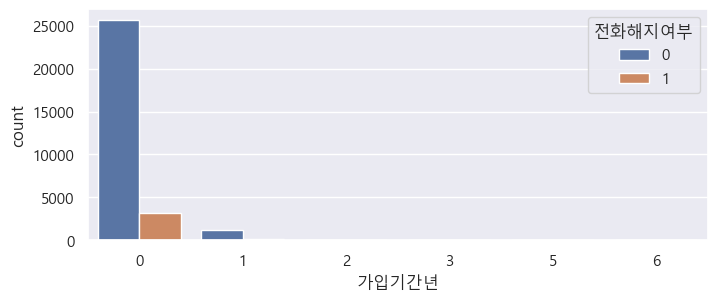

In [15]:
plt.figure(figsize=(8,3))
sns.countplot(data=train    , x='가입기간년',  hue="전화해지여부")
plt.show()

## 가입기간월

In [16]:
train[['가입기간월']].value_counts().sort_index()

가입기간월
0.0       218
1.0      1650
2.0      3195
3.0      1393
4.0       421
5.0      1726
6.0      1455
7.0      3479
8.0      1321
9.0       271
10.0      244
11.0      180
12.0      119
13.0       96
14.0       53
15.0       37
16.0     1492
17.0     1187
18.0     3895
19.0     1950
20.0      686
21.0      308
22.0      266
23.0      974
24.0      823
25.0        6
26.0      722
27.0      661
33.0      185
34.0       84
36.0       71
37.0      649
38.0      129
39.0       49
40.0      159
41.0       16
75.0        4
76.0        1
92.0        6
167.0       4
175.0       6
176.0       3
184.0       6
dtype: int64

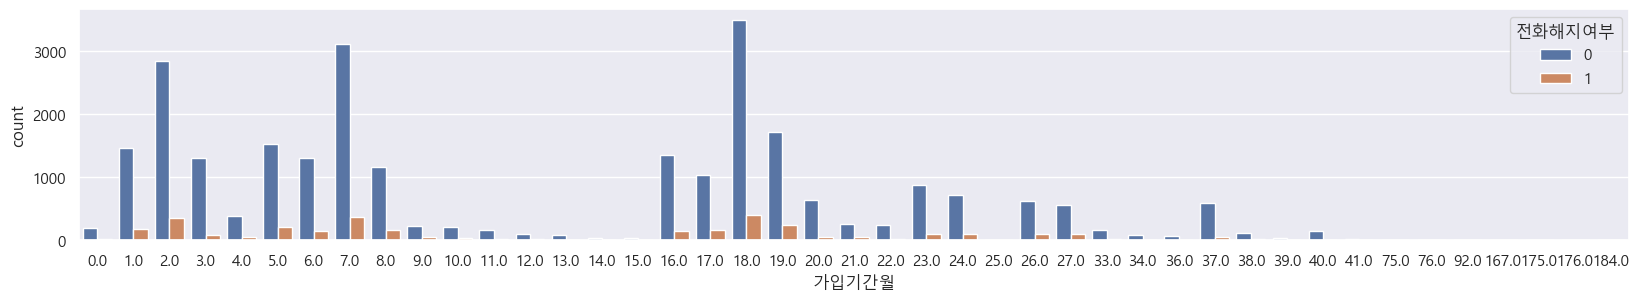

In [17]:
plt.figure(figsize=(20,3))
sns.countplot(data=train    , x='가입기간월', hue="전화해지여부")
plt.show()

## 가입기간주

* 가입기간 17주 이상이면 해지 확률이 거의 없다

In [18]:
train[['가입기간주','전화해지여부']].value_counts().sort_index()

가입기간주  전화해지여부
0.0    0         6044
       1          666
1.0    0         7161
       1          894
2.0    0          778
       1          129
3.0    0         1968
       1          229
4.0    0         6404
       1          795
5.0    0         2099
       1          278
6.0    0         1182
       1          201
7.0    0          244
       1           25
8.0    0          771
       1           78
9.0    0          204
       1           20
17.0   0            4
       1            1
21.0   0            6
38.0   0            2
       1            2
40.0   0            9
42.0   0            6
dtype: int64

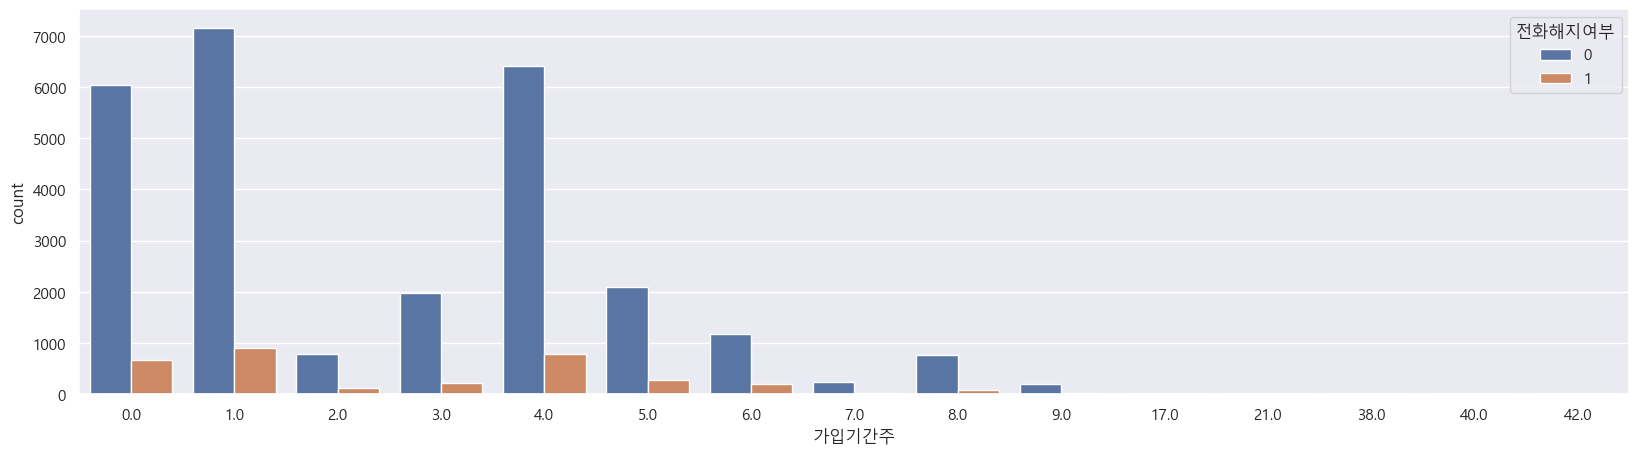

In [19]:
plt.figure(figsize=(20,5))
sns.countplot(data=train    , x='가입기간주', hue="전화해지여부")
plt.show()

## 가입월

* 가입/해지 실적이 저조한 달이 있다
    * 4, 5, 11월 : 매우 저조 
    * 8, 9, 10월 : 상대적 저조 

In [20]:
train[['가입월','전화해지여부']].value_counts().sort_index()

가입월   전화해지여부
0.0   0         3074
      1          364
1.0   0         3368
      1          352
2.0   0         4698
      1          525
3.0   0         3443
      1          484
4.0   0          589
      1           77
5.0   0          170
      1           31
6.0   0         2313
      1          294
7.0   0         5302
      1          661
8.0   0         1123
      1          120
9.0   0         1605
      1          209
10.0  0         1145
      1          189
11.0  0           52
      1           12
dtype: int64

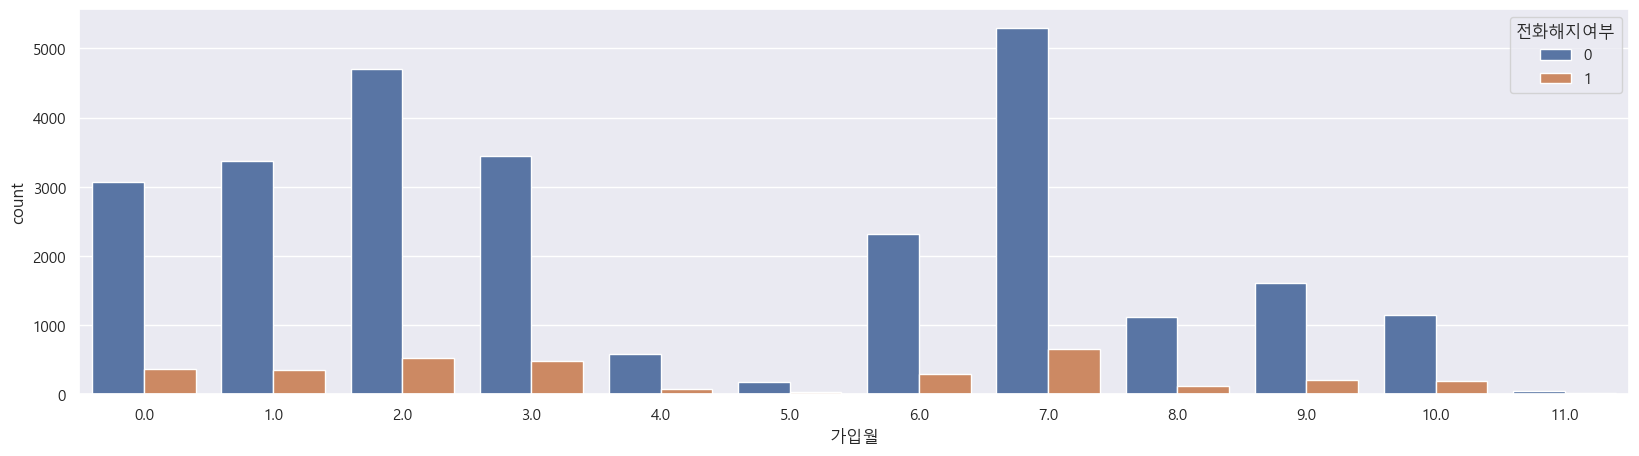

In [21]:
plt.figure(figsize=(20,5))
sns.countplot(data=train    , x='가입월', hue="전화해지여부")
plt.show()

## 통화 시간/횟수/요금
* 전체 시간, 횟수, 요금
* 단위 시간당 요금
* 1회 통화 시간

In [22]:
train['총통화시간']   = train['주간통화시간'] + train['저녁통화시간'] + train['밤통화시간']
train['총통화횟수']   = train['주간통화횟수'] + train['저녁통화횟수'] + train['밤통화횟수']
train['총통화요금']   = train['주간통화요금'] + train['저녁통화요금'] + train['밤통화요금']
train['시간당요금']   = train['총통화요금']   / train['총통화시간']
train['횟수당시간']   = train['총통화시간']   / train['총통화횟수']


test['총통화시간']   = test['주간통화시간'] + test['저녁통화시간'] + test['밤통화시간']
test['총통화횟수']   = test['주간통화횟수'] + test['저녁통화횟수'] + test['밤통화횟수']
test['총통화요금']   = test['주간통화요금'] + test['저녁통화요금'] + test['밤통화요금']
test['시간당요금']   = test['총통화요금']   / test['총통화시간']
test['횟수당시간']   = test['총통화시간']   / test['총통화횟수']

In [166]:
# 분석

## 시간당 요금

- 0인값 대체하기

In [23]:
idx=train['주간통화시간'][train['주간통화시간']==0].index.values

In [24]:
idx

array([5512], dtype=int64)

In [25]:
train['주간통화시간'].loc[idx]=0.1

In [26]:
train['주간통화시간'][train['주간통화시간']==0]

Series([], Name: 주간통화시간, dtype: float64)

- 시간당 요금 계산하기

In [27]:
time_list=[ '주간통화시간','주간통화요금','저녁통화시간','저녁통화요금','밤통화시간','밤통화요금',]

for i in range(0,len(time_list),2):    
    print(time_list[i])
    print(time_list[i+1])
    train[f'{time_list[i]}당요금']=train[time_list[i+1]] / train[time_list[i]]

주간통화시간
주간통화요금
저녁통화시간
저녁통화요금
밤통화시간
밤통화요금


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30200 entries, 0 to 30199
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   가입일        30200 non-null  int64  
 1   음성사서함이용    30200 non-null  int64  
 2   주간통화시간     30200 non-null  float64
 3   주간통화횟수     30200 non-null  int64  
 4   주간통화요금     30200 non-null  float64
 5   저녁통화시간     30200 non-null  float64
 6   저녁통화횟수     30200 non-null  int64  
 7   저녁통화요금     30200 non-null  float64
 8   밤통화시간      30200 non-null  float64
 9   밤통화횟수      30200 non-null  int64  
 10  밤통화요금      30200 non-null  float64
 11  상담전화건수     30200 non-null  int64  
 12  전화해지여부     30200 non-null  int64  
 13  가입기간년      30200 non-null  int64  
 14  가입기간월      30200 non-null  float64
 15  가입기간주      30200 non-null  float64
 16  가입월        30200 non-null  float64
 17  총통화시간      30200 non-null  float64
 18  총통화횟수      30200 non-null  int64  
 19  총통화요금      30200 non-null  float64
 20  시간당요금 

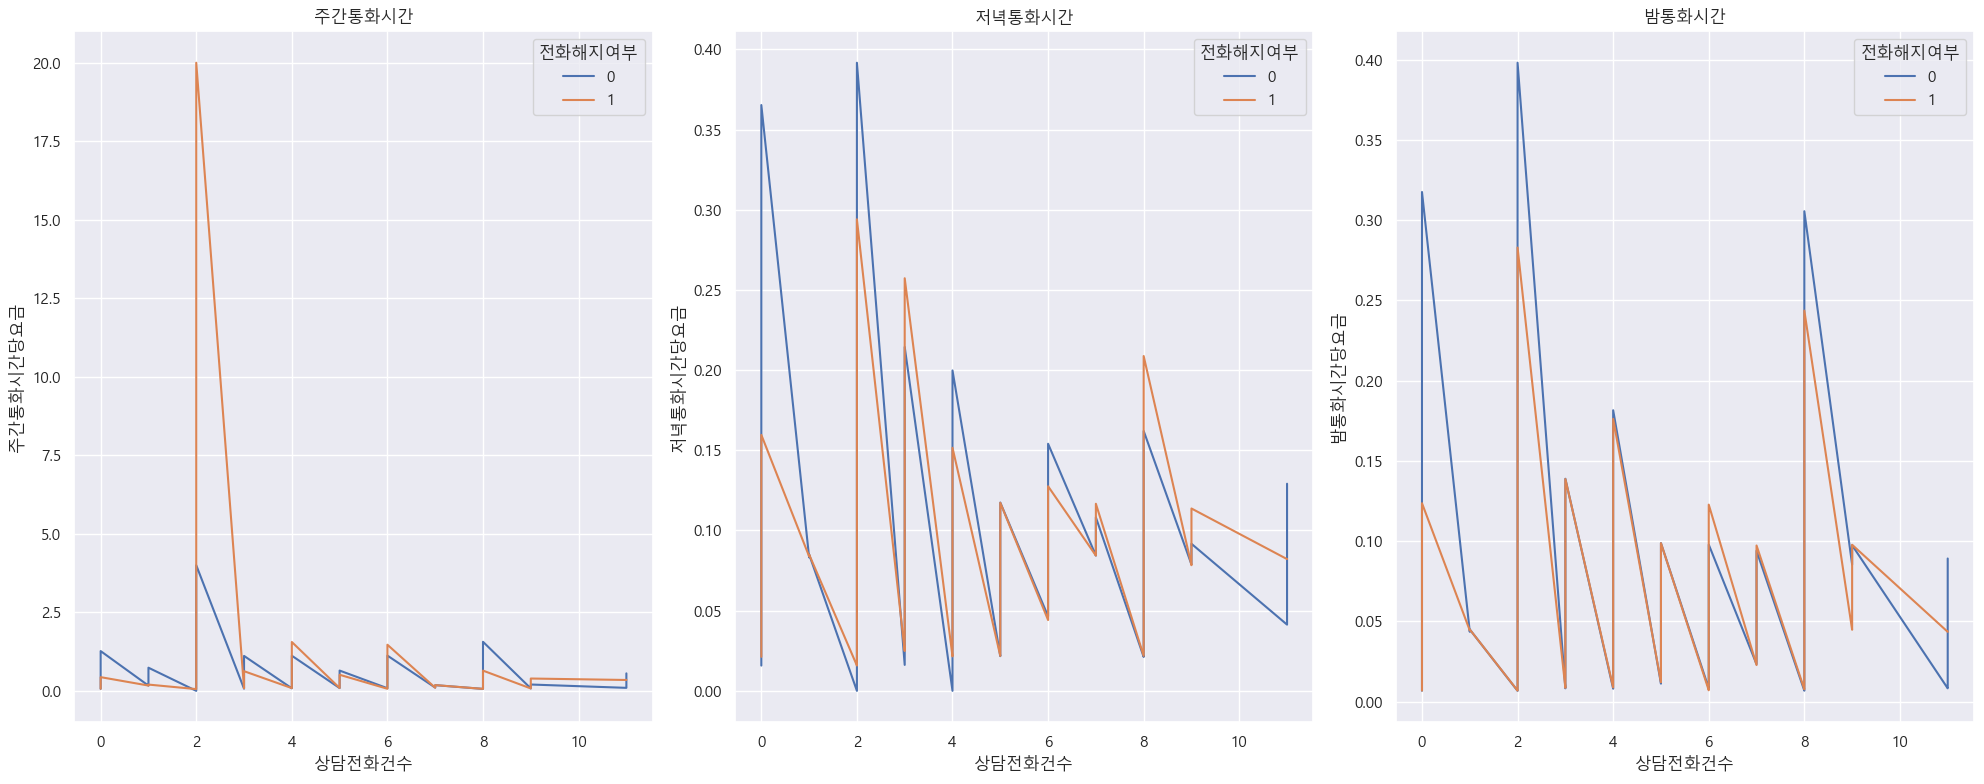

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8)  ) 
x_list=['주간통화시간', '저녁통화시간',  '밤통화시간']
y_list=['주간통화시간당요금', '저녁통화시간당요금', '밤통화시간당요금']
for i, col in enumerate(x_list) :  #train.columns) :
    r = i//6
    c = i%6
    axes[c].set_title(col)
    sns.lineplot(data=train,y=y_list[i],x='상담전화건수', hue='전화해지여부', ax=axes[c],err_style=None, estimator=None)

plt.tight_layout()
plt.show()

In [30]:
train[train['주간통화시간당요금']>=19]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,가입기간년,가입기간월,가입기간주,가입월,총통화시간,총통화횟수,총통화요금,시간당요금,횟수당시간,주간통화시간당요금,저녁통화시간당요금,밤통화시간당요금
15877,94,1,0.1,0,2.0,241.2,230,23.32,263.3,33,2.32,2,1,0,7.0,1.0,3.0,504.6,263,27.64,0.054776,1.918631,20.0,0.096683,0.008811


In [31]:
train[train['주간통화시간']==0.1]

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,가입기간년,가입기간월,가입기간주,가입월,총통화시간,총통화횟수,총통화요금,시간당요금,횟수당시간,주간통화시간당요금,저녁통화시간당요금,밤통화시간당요금
5512,203,1,0.1,0,0.4,292.8,230,26.33,264.5,93,2.60,2,0,0,16.0,3.0,6.0,557.3,323,29.33,0.052629,1.725387,4.0,0.089925,0.009830
11178,98,0,0.1,1,1.2,289.6,280,28.82,263.2,88,2.82,2,1,0,8.0,1.0,3.0,552.9,369,32.84,0.059396,1.498374,12.0,0.099517,0.010714
15877,94,1,0.1,0,2.0,241.2,230,23.32,263.3,33,2.32,2,1,0,7.0,1.0,3.0,504.6,263,27.64,0.054776,1.918631,20.0,0.096683,0.008811


## 월납부요금

In [32]:
train['전화해지여부'][train['가입월']==0.0].value_counts()

0    3074
1     364
Name: 전화해지여부, dtype: int64

In [33]:
traincp=train.copy()

In [34]:
train['가입월']=train['가입월'].astype('int')

In [35]:
test['가입월']=test['가입월'].astype('int')

In [36]:
train['가입월'].value_counts()

7     5963
2     5223
3     3927
1     3720
0     3438
6     2607
9     1814
10    1334
8     1243
4      666
5      201
11      64
Name: 가입월, dtype: int64

In [37]:
test['가입월'].value_counts()

7     2553
2     2335
3     1638
1     1571
0     1456
6     1070
9      780
8      576
10     559
4      291
5       82
11      32
Name: 가입월, dtype: int64

In [38]:
test

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,가입기간년,가입기간월,가입기간주,가입월,총통화시간,총통화횟수,총통화요금,시간당요금,횟수당시간
0,110,0,210.7,142,35.6,205.9,93,17.43,120.9,111,5.37,2,0,9.0,2.0,3,537.5,346,58.40,0.108651,1.553468
1,283,1,268.5,100,30.3,283.0,92,28.32,290.0,89,8.82,0,0,23.0,5.0,9,841.5,281,67.44,0.080143,2.994662
2,34,1,243.3,205,21.3,225.7,205,29.00,92.6,29,2.44,2,0,2.0,0.0,1,561.6,439,52.74,0.093910,1.279271
3,209,86,83.0,93,24.1,270.6,220,22.89,266.9,81,2.80,6,0,17.0,4.0,6,620.5,394,49.79,0.080242,1.574873
4,202,0,293.2,23,31.0,294.0,24,26.39,223.8,33,6.66,2,0,16.0,3.0,6,811.0,80,64.05,0.078977,10.137500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12938,322,1,282.4,202,89.9,270.2,321,32.80,293.6,321,8.88,2,0,26.0,6.0,10,846.2,844,131.58,0.155495,1.002607
12939,222,0,233.5,209,34.6,234.0,92,23.22,224.4,202,9.63,2,0,18.0,4.0,7,691.9,503,67.45,0.097485,1.375547
12940,98,29,223.4,209,29.3,223.9,203,28.82,230.0,208,22.26,2,0,8.0,1.0,3,677.3,620,80.38,0.118677,1.092419
12941,23,30,241.3,222,24.7,234.3,93,22.23,223.1,33,9.93,0,0,1.0,0.0,0,698.7,348,56.86,0.081380,2.007759


In [39]:
for i,var in enumerate(train['가입기간월']):
    if var ==0:  

        # print(i,var)
        train['월납부요금']=train['총통화요금'][i]
    else:
        train['월납부요금']=train['총통화요금'][i]/var

In [40]:
for i,var in enumerate(train['가입기간월']):
    if var ==0:  

        # print(i,var)
        train['월납부요금'][i]=train['총통화요금'][i]
    else:
        train['월납부요금'][i]=train['총통화요금'][i]/var

In [41]:
train.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,가입기간년,가입기간월,가입기간주,가입월,총통화시간,총통화횟수,총통화요금,시간당요금,횟수당시간,주간통화시간당요금,저녁통화시간당요금,밤통화시간당요금,월납부요금
0,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0,0,27.0,6.0,10,630.9,489,89.11,0.141243,1.290184,0.275202,0.107589,0.125105,3.300370
1,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0,0,0.0,0.0,0,916.1,858,148.11,0.161674,1.067716,0.258413,0.119117,0.100124,148.110000
2,93,28,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0,0,7.0,1.0,3,770.2,973,75.30,0.097767,0.791572,0.121105,0.158551,0.029487,10.757143
3,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0,0,18.0,4.0,7,658.2,518,58.36,0.088666,1.270656,0.113369,0.102575,0.045927,3.242222
4,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0,0,18.0,4.0,7,583.3,514,59.58,0.102143,1.134825,0.298027,0.125413,0.010642,3.310000


In [42]:
for i,var in enumerate(test['가입기간월']):
    if var ==0:  

        # print(i,var)
        test['월납부요금']=test['총통화요금'][i]
    else:
        test['월납부요금']=test['총통화요금'][i]/var

In [43]:
for i,var in enumerate(test['가입기간월']):
    if var ==0:  

        # print(i,var)
        test['월납부요금'][i]=test['총통화요금'][i]
    else:
        test['월납부요금'][i]=test['총통화요금'][i]/var

In [44]:
test.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,가입기간년,가입기간월,가입기간주,가입월,총통화시간,총통화횟수,총통화요금,시간당요금,횟수당시간,월납부요금
0,110,0,210.7,142,35.6,205.9,93,17.43,120.9,111,5.37,2,0,9.0,2.0,3,537.5,346,58.40,0.108651,1.553468,6.488889
1,283,1,268.5,100,30.3,283.0,92,28.32,290.0,89,8.82,0,0,23.0,5.0,9,841.5,281,67.44,0.080143,2.994662,2.932174
2,34,1,243.3,205,21.3,225.7,205,29.00,92.6,29,2.44,2,0,2.0,0.0,1,561.6,439,52.74,0.093910,1.279271,26.370000
3,209,86,83.0,93,24.1,270.6,220,22.89,266.9,81,2.80,6,0,17.0,4.0,6,620.5,394,49.79,0.080242,1.574873,2.928824
4,202,0,293.2,23,31.0,294.0,24,26.39,223.8,33,6.66,2,0,16.0,3.0,6,811.0,80,64.05,0.078977,10.137500,4.003125


## 월 통화시간, 월 통화횟수 

### 월통화시간 train, test

In [45]:
for i,var in enumerate(train['가입기간월']):
    if var ==0:  

        # print(i,var)
        train['월통화시간']=train['총통화시간'][i]
    else:
        train['월통화시간']=train['총통화시간'][i]/var

In [46]:
for i,var in enumerate(train['가입기간월']):
    if var ==0:  

        # print(i,var)
        train['월통화시간'][i]=train['총통화시간'][i]
    else:
        train['월통화시간'][i]=train['총통화시간'][i]/var

In [47]:
for i,var in enumerate(test['가입기간월']):
    if var ==0:  

        # print(i,var)
        test['월통화시간']=test['총통화시간'][i]
    else:
        test['월통화시간']=test['총통화시간'][i]/var

In [48]:
for i,var in enumerate(test['가입기간월']):
    if var ==0:  

        # print(i,var)
        test['월통화시간'][i]=test['총통화시간'][i]
    else:
        test['월통화시간'][i]=test['총통화시간'][i]/var

In [49]:
train.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,가입기간년,가입기간월,가입기간주,가입월,총통화시간,총통화횟수,총통화요금,시간당요금,횟수당시간,주간통화시간당요금,저녁통화시간당요금,밤통화시간당요금,월납부요금,월통화시간
0,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0,0,27.0,6.0,10,630.9,489,89.11,0.141243,1.290184,0.275202,0.107589,0.125105,3.300370,23.366667
1,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0,0,0.0,0.0,0,916.1,858,148.11,0.161674,1.067716,0.258413,0.119117,0.100124,148.110000,916.100000
2,93,28,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0,0,7.0,1.0,3,770.2,973,75.30,0.097767,0.791572,0.121105,0.158551,0.029487,10.757143,110.028571
3,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0,0,18.0,4.0,7,658.2,518,58.36,0.088666,1.270656,0.113369,0.102575,0.045927,3.242222,36.566667
4,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0,0,18.0,4.0,7,583.3,514,59.58,0.102143,1.134825,0.298027,0.125413,0.010642,3.310000,32.405556


### 월통화횟수 train, test

In [50]:
for i,var in enumerate(train['가입기간월']):
    if var ==0:  

        # print(i,var)
        train['월통화횟수']=train['총통화횟수'][i]
    else:
        train['월통화횟수']=train['총통화횟수'][i]/var

In [51]:
for i,var in enumerate(train['가입기간월']):
    if var ==0:  

        # print(i,var)
        train['월통화횟수'][i]=train['총통화횟수'][i]
    else:
        train['월통화횟수'][i]=train['총통화횟수'][i]/var

In [52]:
for i,var in enumerate(test['가입기간월']):
    if var ==0:  

        # print(i,var)
        test['월통화횟수']=test['총통화횟수'][i]
    else:
        test['월통화횟수']=test['총통화횟수'][i]/var

In [53]:
for i,var in enumerate(test['가입기간월']):
    if var ==0:  

        # print(i,var)
        test['월통화횟수'][i]=test['총통화횟수'][i]
    else:
        test['월통화횟수'][i]=test['총통화횟수'][i]/var

In [54]:
test.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,가입기간년,가입기간월,가입기간주,가입월,총통화시간,총통화횟수,총통화요금,시간당요금,횟수당시간,월납부요금,월통화시간,월통화횟수
0,110,0,210.7,142,35.6,205.9,93,17.43,120.9,111,5.37,2,0,9.0,2.0,3,537.5,346,58.40,0.108651,1.553468,6.488889,59.722222,38.444444
1,283,1,268.5,100,30.3,283.0,92,28.32,290.0,89,8.82,0,0,23.0,5.0,9,841.5,281,67.44,0.080143,2.994662,2.932174,36.586957,12.217391
2,34,1,243.3,205,21.3,225.7,205,29.00,92.6,29,2.44,2,0,2.0,0.0,1,561.6,439,52.74,0.093910,1.279271,26.370000,280.800000,219.500000
3,209,86,83.0,93,24.1,270.6,220,22.89,266.9,81,2.80,6,0,17.0,4.0,6,620.5,394,49.79,0.080242,1.574873,2.928824,36.500000,23.176471
4,202,0,293.2,23,31.0,294.0,24,26.39,223.8,33,6.66,2,0,16.0,3.0,6,811.0,80,64.05,0.078977,10.137500,4.003125,50.687500,5.000000


### 가입 시기에 따른 월납부요금 그래프

<AxesSubplot: xlabel='가입월', ylabel='월납부요금'>

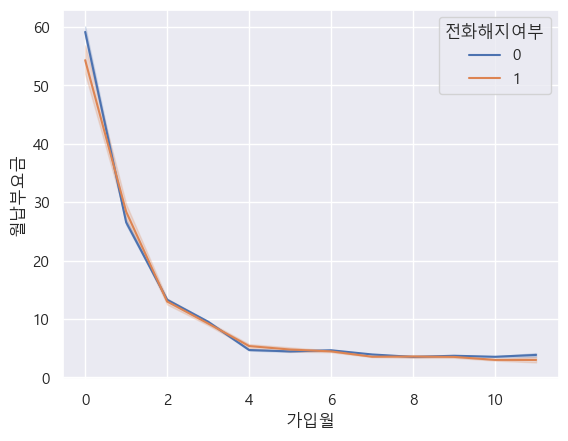

In [55]:
sns.lineplot(data=train,y='월납부요금',x='가입월',hue='전화해지여부')

### 월납부요금에 따른 상담전화 건수 번화

<AxesSubplot: xlabel='상담전화건수', ylabel='월납부요금'>

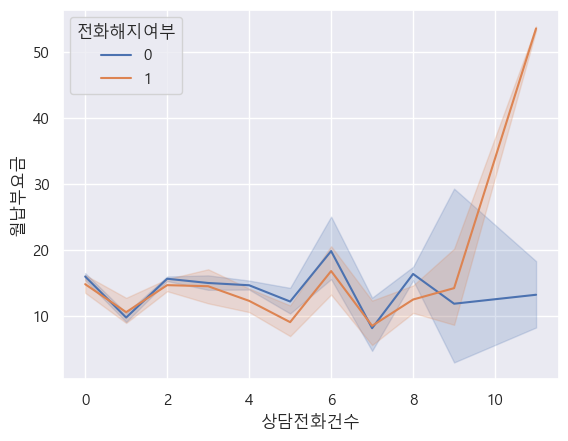

In [56]:
sns.lineplot(data=train,y='월납부요금',x='상담전화건수', hue='전화해지여부')

* 건수 8번까지는 납부요금이 상담과 상관이 크게 없다.
* 그 이상부터는 납부요금이 커서 해지 상담을 했을 가능성이 높다.

In [57]:
train[['전화해지여부','상담전화건수']].value_counts().sort_index()

전화해지여부  상담전화건수
0       0          5696
        1           754
        2         14844
        3           986
        4          2288
        5           176
        6            91
        7             6
        8          2021
        9             3
        11           17
1       0           607
        1            80
        2          1678
        3           194
        4           252
        5            58
        6           112
        7             7
        8           313
        9            15
        11            2
dtype: int64

In [58]:
train[['가입기간년','시간당요금','총통화시간','월납부요금','전화해지여부']][(train['상담전화건수']>=8)&(train['전화해지여부']==1)].sort_values('시간당요금',ascending= False)

,가입기간년,시간당요금,총통화시간,월납부요금,전화해지여부
11995,0,0.200822,657.2,5.738261,1
5006,0,0.198387,657.2,5.668696,1
1850,0,0.191967,662.3,21.190000,1
7550,0,0.189833,662.9,20.973333,1
7268,0,0.187681,683.5,6.751579,1
...,...,...,...,...,...
14983,0,0.058883,777.3,2.408947,1
26919,1,0.049892,1337.5,1.803514,1
1866,0,0.048255,977.3,2.050435,1
5914,0,0.047615,972.6,1.781154,1


In [59]:
train[['가입기간년','시간당요금','총통화시간','월납부요금','전화해지여부']][(train['상담전화건수']>=8)&(train['전화해지여부']==0)].sort_values('시간당요금',ascending= False)

,가입기간년,시간당요금,총통화시간,월납부요금,전화해지여부
14373,0,0.235744,677.6,19.967500,0
9648,0,0.234076,677.3,19.817500,0
27021,0,0.232794,653.8,21.743000,0
15493,0,0.231382,653.9,21.614429,0
27826,0,0.214985,604.6,5.651304,0
...,...,...,...,...,...
20580,0,0.051391,801.3,2.422353,0
5262,1,0.050224,1338.6,1.817027,0
24912,0,0.049424,781.0,7.720000,0
26877,1,0.048030,1322.1,1.867647,0


In [60]:
train[['가입기간년','시간당요금','총통화시간','월납부요금','전화해지여부']][train['상담전화건수']>=8].sort_values('월납부요금',ascending= False)

,가입기간년,시간당요금,총통화시간,월납부요금,전화해지여부
29195,0,0.163123,863.4,140.840000,0
25032,0,0.168615,797.2,134.420000,0
870,0,0.167675,796.9,133.620000,0
1933,0,0.167655,795.8,133.420000,0
9417,0,0.167069,795.6,132.920000,0
...,...,...,...,...,...
20765,0,0.053877,601.0,1.349167,0
8347,0,0.074018,450.7,1.235556,1
489,0,0.072751,450.3,1.213333,1
16603,3,0.095964,550.5,0.574217,0


In [61]:
tot_cost_cut = pd.cut(train['월납부요금'],6)
tot_cost_cut=tot_cost_cut.cat.codes

In [62]:
tot_cost_cut_test = pd.cut(test['월납부요금'],6)
tot_cost_cut_test=tot_cost_cut_test.cat.codes

In [63]:
# (2.956, 33.234], (33.234, 63.331], (63.331, 93.428], (93.428, 123.526], (123.526, 153.623], (153.623, 183.72]
# (2.806, 33.154], (33.154, 63.321], (63.321, 93.488], (93.488, 123.656], (123.656, 153.823], (153.823, 183.99]

In [64]:
train['월납부요금구간'] = tot_cost_cut

In [65]:
test['월납부요금구간'] = tot_cost_cut_test

In [66]:
test.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,가입기간년,가입기간월,가입기간주,가입월,총통화시간,총통화횟수,총통화요금,시간당요금,횟수당시간,월납부요금,월통화시간,월통화횟수,월납부요금구간
0,110,0,210.7,142,35.6,205.9,93,17.43,120.9,111,5.37,2,0,9.0,2.0,3,537.5,346,58.40,0.108651,1.553468,6.488889,59.722222,38.444444,0
1,283,1,268.5,100,30.3,283.0,92,28.32,290.0,89,8.82,0,0,23.0,5.0,9,841.5,281,67.44,0.080143,2.994662,2.932174,36.586957,12.217391,0
2,34,1,243.3,205,21.3,225.7,205,29.00,92.6,29,2.44,2,0,2.0,0.0,1,561.6,439,52.74,0.093910,1.279271,26.370000,280.800000,219.500000,1
3,209,86,83.0,93,24.1,270.6,220,22.89,266.9,81,2.80,6,0,17.0,4.0,6,620.5,394,49.79,0.080242,1.574873,2.928824,36.500000,23.176471,0
4,202,0,293.2,23,31.0,294.0,24,26.39,223.8,33,6.66,2,0,16.0,3.0,6,811.0,80,64.05,0.078977,10.137500,4.003125,50.687500,5.000000,0


In [67]:
train.describe()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,가입기간년,가입기간월,가입기간주,가입월,총통화시간,총통화횟수,총통화요금,시간당요금,횟수당시간,주간통화시간당요금,저녁통화시간당요금,밤통화시간당요금,월납부요금,월통화시간,월통화횟수,월납부요금구간
count,30200.000000,30200.000000,30200.00000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000,30200.000000
mean,159.732649,12.037815,250.56346,159.175728,41.091447,263.247215,158.474536,25.394260,263.438285,157.047417,12.074648,2.288079,0.109868,0.048709,12.808841,2.553146,4.215662,777.248957,474.697682,78.560356,0.101774,1.905340,0.184063,0.097251,0.047064,15.322813,151.177745,91.888401,0.226258
std,123.752781,24.925334,84.40334,101.573057,23.179017,74.064922,102.200293,8.146126,73.778416,101.721601,9.414261,2.050746,0.312730,0.249862,10.348613,2.438045,3.112707,192.815336,198.109400,28.954492,0.031296,0.987688,0.189984,0.021319,0.034361,20.280452,184.090756,120.860557,0.626653
min,1.000000,0.000000,0.10000,0.000000,0.000000,0.100000,0.000000,0.000000,20.800000,20.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,264.700000,72.000000,17.040000,0.041996,0.467341,0.000000,0.000000,0.006792,0.227086,3.647826,1.804348,0.000000
25%,63.000000,0.000000,222.80000,88.000000,24.400000,223.700000,87.000000,22.220000,223.700000,87.000000,4.700000,2.000000,0.000000,0.000000,5.000000,1.000000,2.000000,678.800000,331.000000,57.400000,0.078959,1.331795,0.103082,0.086233,0.018052,3.613838,38.021930,23.649265,0.000000
50%,118.000000,1.000000,234.00000,117.500000,30.800000,243.000000,112.000000,23.320000,242.800000,108.000000,9.080000,2.000000,0.000000,0.000000,9.000000,2.000000,3.000000,735.300000,466.000000,68.890000,0.094919,1.630376,0.132839,0.097686,0.041727,6.998992,61.028125,36.782609,0.000000
75%,228.000000,22.000000,289.60000,223.000000,45.900000,290.300000,223.000000,28.820000,290.500000,222.000000,20.290000,2.000000,0.000000,0.000000,19.000000,4.000000,7.000000,829.800000,576.000000,95.830000,0.111973,2.156366,0.207796,0.107290,0.079529,18.759643,171.360000,103.200000,0.000000
max,2212.000000,1112.000000,481.90000,489.000000,118.600000,481.600000,489.000000,49.980000,481.800000,490.000000,44.980000,11.000000,1.000000,6.000000,184.000000,42.000000,11.000000,1432.100000,1427.000000,184.240000,0.264979,10.925287,20.000000,0.391630,0.398077,174.630000,1385.200000,1300.000000,5.000000


### 누적 가입 기간에 따른 월 납부 요금

<AxesSubplot: xlabel='가입기간월', ylabel='월납부요금'>

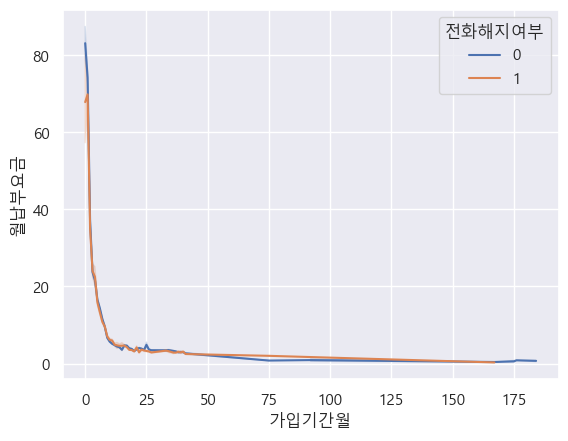

In [68]:
sns.lineplot(data=train,y='월납부요금',x='가입기간월',hue='전화해지여부')

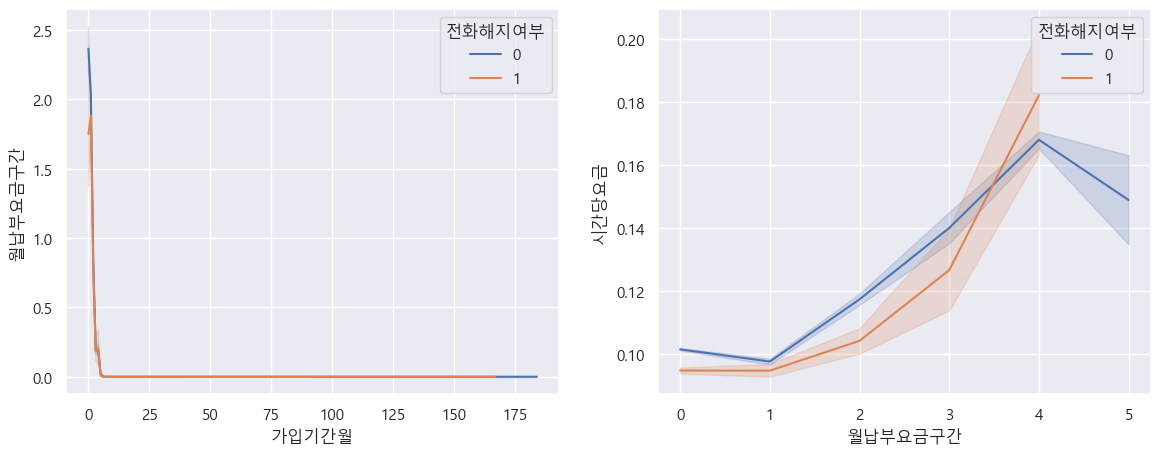

In [105]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

sns.lineplot(data=train,y='월납부요금구간',x='가입기간월',hue='전화해지여부', ax=axes[0])
sns.lineplot(data=train,y='시간당요금',x='월납부요금구간',hue='전화해지여부', ax=axes[1])
plt.show()

<pre>

* 초기 가입기간부터 5개월까지 급격하게 감소한다. = 초기 납부 비용이 가장 크다.

* 5개월 이후부터는 고정 요금이다

  ==> 초기 5개월동안 약정, 기계값 등이 포함되어있는 것 같다...?

### 월별 값에 따른 전화해지여부(구간) 

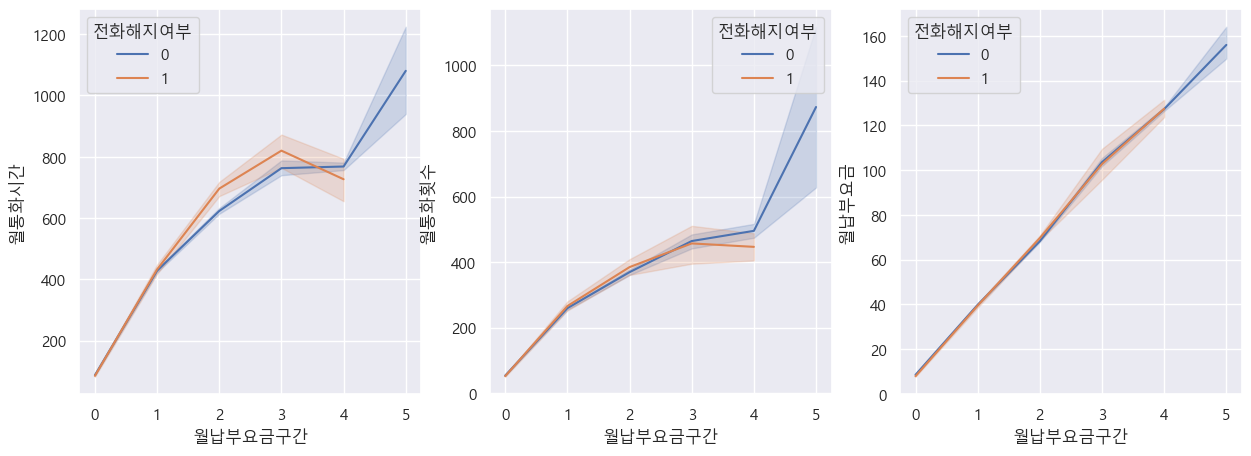

In [102]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

sns.lineplot(data=train,y='월통화시간',x='월납부요금구간',hue='전화해지여부', ax=axes[0])
sns.lineplot(data=train,y='월통화횟수',x='월납부요금구간',hue='전화해지여부', ax=axes[1])
sns.lineplot(data=train,y='월납부요금',x='월납부요금구간',hue='전화해지여부', ax=axes[2])
plt.show()

- 첫번째 그래프 : 월납부요금구간 3-4 일때, 해지한 사람들의 경우 월통화시간이 줄어들었음에도 월납부요금이 증가  --> 해지?
- 해지할 사람은 4구간에서 해지했을 것이다. 오히려 5구간에 가면 해지할 마음이 없음.

In [104]:
train[['전화해지여부','월납부요금구간']].value_counts().sort_index()

전화해지여부  월납부요금구간
0       0          22891
        1           2442
        2           1175
        3            140
        4            224
        5             10
1       0           2840
        1            317
        2            139
        3              8
        4             14
dtype: int64

<pre>

* 4-5구간 : 14명 해지
* 5구간 : 0명 해지

 = 월납부요금이 큰 사람은 해지를 안했다.

In [73]:
train['월납부요금'].describe()

count    30200.000000
mean        15.322813
std         20.280452
min          0.227086
25%          3.613838
50%          6.998992
75%         18.759643
max        174.630000
Name: 월납부요금, dtype: float64

In [112]:
train[['전화해지여부','월납부요금구간']][train['월납부요금구간']==4].value_counts().sort_index()

전화해지여부  월납부요금구간
0       4          224
1       4           14
dtype: int64

In [125]:
train['월납부요금'][(train['월납부요금구간']==4) & (train['전화해지여부']==1)].sort_values().describe()

count     14.000000
mean     127.407143
std        7.770928
min      118.970000
25%      120.302500
50%      128.380000
75%      130.575000
max      139.740000
Name: 월납부요금, dtype: float64

In [126]:
train['월납부요금'][(train['월납부요금구간']==4) & (train['전화해지여부']==0)].sort_values().describe()

count    224.000000
mean     127.225612
std        6.950327
min      116.580000
25%      120.740000
50%      126.565000
75%      132.035000
max      144.709000
Name: 월납부요금, dtype: float64

### heatmap

In [75]:
large_col = train.corr().nlargest(5, '가입일').index.values
small_col = train.corr().nsmallest(4, '가입일').index.values
print(large_col, small_col)

['가입일' '가입기간월' '가입기간주' '가입월' '가입기간년'] ['월통화시간' '월통화횟수' '월납부요금' '월납부요금구간']


## 다중공선 select

In [162]:
large_col = ['가입일' ,'가입기간월', '가입기간주', '가입월', '가입기간년'] 
small_col = ['월통화시간', '월통화횟수', '월납부요금', '월납부요금구간']

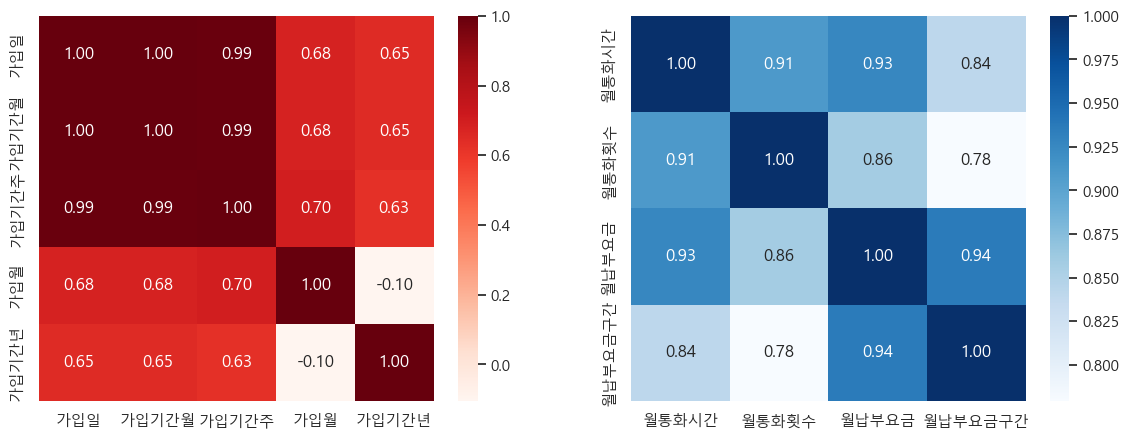

In [163]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

sns.heatmap(train[large_col].corr(), fmt=".2f", cmap="Reds",  annot=True, ax=axes[0])
sns.heatmap(train[small_col].corr(), fmt=".2f", cmap="Blues", annot=True, ax=axes[1])
plt.show()

<AxesSubplot: >

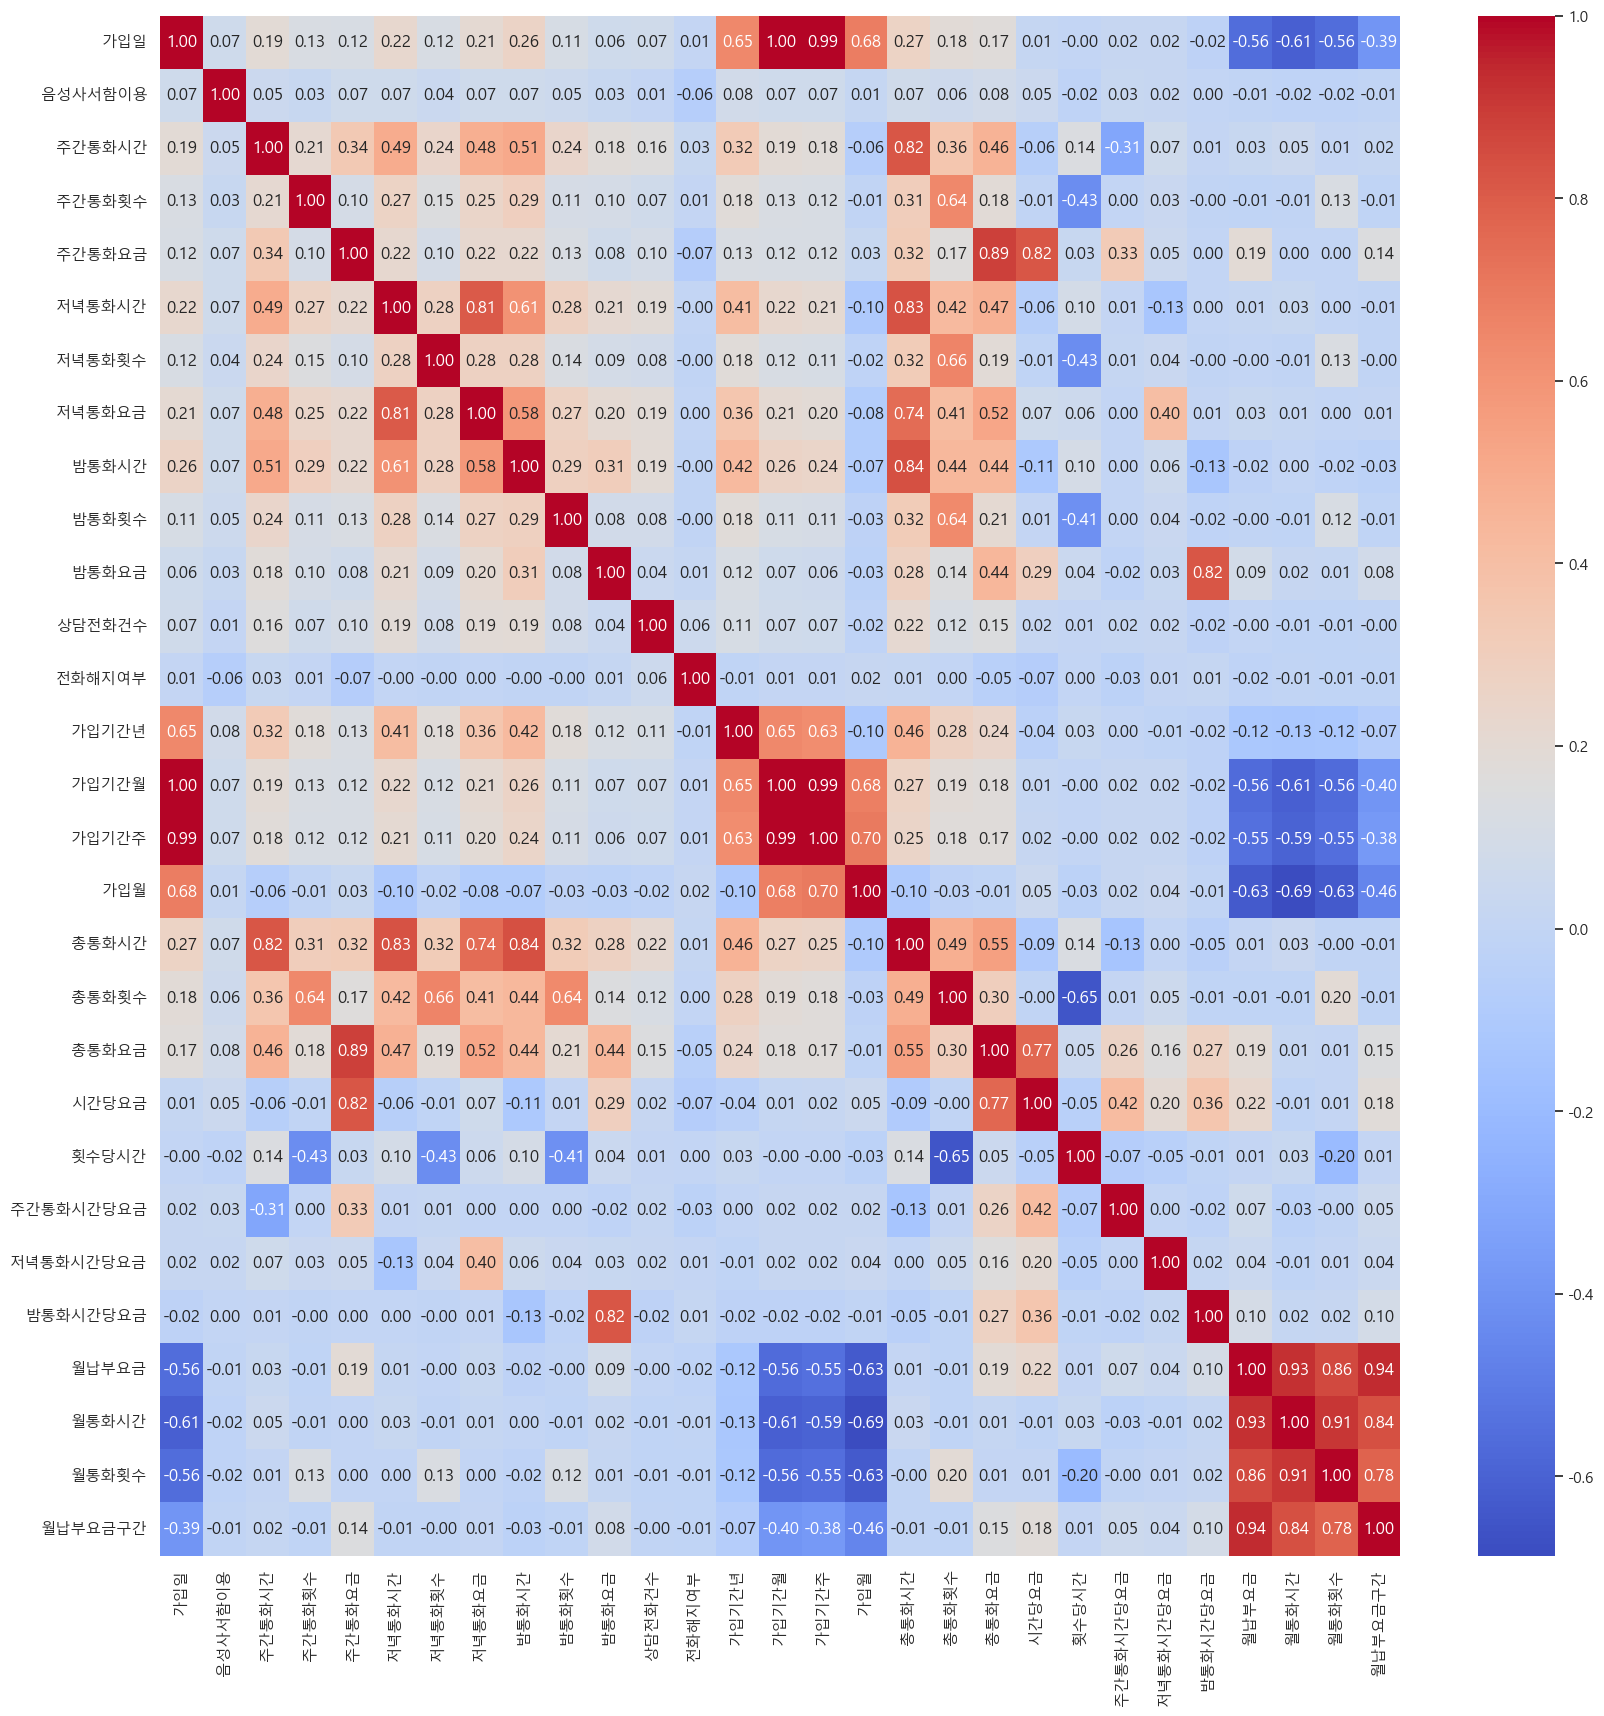

In [164]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(),annot=True, fmt=".2f", cmap='coolwarm')

In [139]:
test.columns

Index(['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '가입기간년', '가입기간월',
       '가입기간주', '가입월', '총통화시간', '총통화횟수', '총통화요금', '시간당요금', '횟수당시간', '월납부요금',
       '월통화시간', '월통화횟수', '월납부요금구간'],
      dtype='object')

### 점수

- 원본 넣은 것

In [165]:
y=train['전화해지여부']
X=train.drop('전화해지여부',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X, y , test_size=0.2, random_state=0)
model = ExtraTreesClassifier(max_depth=50, n_estimators=200, random_state=0)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print(  confusion_matrix(y_test,  pred)   )
print(f"정확도: {accuracy_score(y_test, pred):.4f}, 정밀도: {precision_score(y_test, pred):.4f}, 재현율: {recall_score(y_test, pred):.4f}, F1: {f1_score(y_test, pred):.4f}")

[[5219  135]
 [ 337  349]]
정확도: 0.9219, 정밀도: 0.7211, 재현율: 0.5087, F1: 0.5966


### 살릴 컬럼 선택

<pre>

select_test=test[['가입기간월', '가입기간주', '가입기간년', '가입월','총통화시간', '총통화횟수', '총통화요금','시간당요금','상담전화건수','월납부요금']].copy()

In [141]:
select_train=train[['가입기간월', '가입기간주', '가입기간년', '가입월','월통화시간', '월통화횟수','시간당요금','상담전화건수','월납부요금','월납부요금구간','전화해지여부']].copy()

In [142]:
select_test=test[['가입기간월', '가입기간주', '가입기간년', '가입월','월통화시간', '월통화횟수','시간당요금','상담전화건수','월납부요금','월납부요금구간']].copy()

In [143]:
y=select_train['전화해지여부']
X=select_train.drop('전화해지여부',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X, y , test_size=0.2, random_state=11)
model = ExtraTreesClassifier(max_depth=50, n_estimators=200, random_state=11)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print(  confusion_matrix(y_test,  pred)   )
print(f"정확도: {accuracy_score(y_test, pred):.4f}, 정밀도: {precision_score(y_test, pred):.4f}, 재현율: {recall_score(y_test, pred):.4f}, F1: {f1_score(y_test, pred):.4f}")

[[5230  153]
 [ 372  285]]
정확도: 0.9131, 정밀도: 0.6507, 재현율: 0.4338, F1: 0.5205


In [144]:
skf= StratifiedKFold(n_splits=5,shuffle=True, random_state=11)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    
    X_train= X.loc[train_index]
    X_test= X.loc[test_index]
    y_train=y.loc[train_index]
    y_test=y.loc[test_index]
    

In [145]:
# model=ExtraTreesClassifier(max_depth=50, n_estimators=200, random_state=11, criterion= 'gini')

# score_dict=cross_validate(model,X, y,scoring='accuracy',cv=skf)

# print(f"정확도: {accuracy_score(y_test, pred):.4f}, 정밀도: {precision_score(y_test, pred):.4f}, 재현율: {recall_score(y_test, pred):.4f}, F1: {f1_score(y_test, pred):.4f}")

In [146]:
select_test=test[['가입기간월', '가입기간주', '가입기간년', '가입월','총통화시간', '총통화횟수', '총통화요금','시간당요금','상담전화건수','월납부요금']].copy()

# 그리드 ET <f1 : 72 - 47~>

In [147]:
# 그리드 ET <f1 : 71>

model=ExtraTreesClassifier(random_state=11)
mydic={"max_depth":[49,50,51],
       "n_estimators":[100,200,300]}  # 손댈 자신 없으면 건들지 말기
models= GridSearchCV(model, scoring='f1_macro', cv=skf, param_grid=mydic)

models.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
             estimator=ExtraTreesClassifier(random_state=11),
             param_grid={'max_depth': [49, 50, 51],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_macro')

In [148]:
models.best_estimator_

ExtraTreesClassifier(max_depth=49, n_estimators=300, random_state=11)

In [149]:
models.best_score_

0.7201769937531269

In [150]:
models.best_params_

{'max_depth': 49, 'n_estimators': 300}

In [151]:
pred=models.predict(select_test)  # 공전 문제 --> pred 답안제출

### 제출

In [152]:
# select_test=select_test.drop('ID',axis=1)

In [153]:
sub=pd.read_csv('sample_submission.csv')
sub['전화해지여부']=pred
sub.to_csv('submit4.csv',index=False)

In [154]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [155]:
# y_pred=model.predict(X_test)

NotFittedError: This ExtraTreesClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## 은경님 코드(0.93 - 80~)

In [156]:
from imblearn.over_sampling import ADASYN
y=select_train['전화해지여부']
X=select_train.drop('전화해지여부',axis=1)
X, y = ADASYN(random_state=21).fit_resample(X, y)
X_train,X_test,y_train,y_test = train_test_split(X, y , test_size=0.2, random_state=21)
model = ExtraTreesClassifier( random_state=21,max_depth= 49, n_estimators= 300)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print(  confusion_matrix(y_test,  pred)   )
print(f"정확도: {accuracy_score(y_test, pred):.4f}, 정밀도: {precision_score(y_test, pred):.4f}, 재현율: {recall_score(y_test, pred):.4f}, F1: {f1_score(y_test, pred):.4f}")

[[4965  422]
 [ 331 5018]]
정확도: 0.9299, 정밀도: 0.9224, 재현율: 0.9381, F1: 0.9302


In [158]:
은경pred=model.predict(select_test)

### over

In [ ]:
from imblearn.over_sampling import SMOTE

y = select_train['전화해지여부']
X = select_train.drop(['전화해지여부'], axis=1)

X_s, y_s = SMOTE(sampling_strategy='auto', random_state=21).fit_resample(X,y)
print(  len(X_s), len(y_s) )

y_s.value_counts()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_s, y_s , test_size=0.2, random_state=21)
model = ExtraTreesClassifier( random_state=11,max_depth=50, n_estimators=200)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print(  confusion_matrix(y_test,  pred)   )
print(f"정확도: {accuracy_score(y_test, pred):.4f}, 정밀도: {precision_score(y_test, pred):.4f}, 재현율: {recall_score(y_test, pred):.4f}, F1: {f1_score(y_test, pred):.4f}")

In [ ]:
pred = model.predict(select_test)

### 제출

In [ ]:
# select_test=select_test.drop('ID',axis=1)

In [159]:
sub=pd.read_csv('sample_submission.csv')
sub['전화해지여부']=은경pred
sub.to_csv('submit은경.csv',index=False)

In [ ]:
from sklearn.metrics import SCORERS
SCORERS.keys()

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
dfasdfsd

# 음성사서함이용

In [ ]:
train[['음성사서함이용','전화해지여부']].value_counts().sort_index()

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(data=train    , x='음성사서함이용', hue="전화해지여부")
plt.show()

# 상담전화건수

In [ ]:
train[['상담전화건수','전화해지여부']].value_counts().sort_index()

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(data=train    , x='상담전화건수', hue="전화해지여부")
plt.show()

* 월별 상담전화건수

In [ ]:
train.groupby(['가입기간월','전화해지여부'])['상담전화건수'].mean()

In [ ]:
temp = train.groupby(['가입기간월','전화해지여부'])['상담전화건수'].mean().reset_index()
temp.head()

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(data=temp    , x='가입기간월', y='상담전화건수', hue="전화해지여부")
plt.show()

# 히스토그램

In [ ]:
train.hist(figsize=(20,15))
plt.tight_layout()
plt.show()

In [ ]:
len(train.columns), len(test.columns)

# train test 분포

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20)  ) 

for i, col in enumerate(test.columns) :
    r = i//4
    c = i%4
    axes[r][c].set_title(col)
    sns.histplot(data=train, x=col, ax=axes[r][c],  kde=True )
    sns.histplot(data=test, x=col, ax=axes[r][c],   kde=True )

plt.tight_layout()
plt.show()


# train 0 , 1 분포

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8)  ) 

for i, col in enumerate(['가입일','음성사서함이용','상담전화건수']) :
    r = i//3
    c = i%3
    axes[r][c].set_title(col)
    sns.histplot(data=train[train['전화해지여부']==0], x=col, ax=axes[r][c],     kde=True )
    sns.histplot(data=train[train['전화해지여부']==1], x=col, ax=axes[r][c],     kde=True )

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12)  ) 

for i, col in enumerate(['주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금']) :
    r = i//3
    c = i%3
    axes[r][c].set_title(col)
    sns.histplot(data=train[train['전화해지여부']==0], x=col, ax=axes[r][c],     kde=True )
    sns.histplot(data=train[train['전화해지여부']==1], x=col, ax=axes[r][c],     kde=True )

plt.tight_layout()
plt.show()

* 주간,저녁,밤 : 통화시간 통화횟수는 비슷한 패턴을 보인다
* <b>주간,저녁,밤 : 통화요금은 다른 패턴을 보인다 --> 요금제????

# 박스플롯 (아웃라이어)

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20,20))

for i, col in enumerate(test.columns) :
    r = i//4
    c = i%4
    sns.boxplot(data=train, y=col, x="전화해지여부", ax=axes[r][c])
    axes[r][c].set_title(col) 
plt.tight_layout()    
plt.show()

# 데이터 분포(scatter)

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20,20))

for i, col in enumerate(test.columns) :
    r = i//4
    c = i%4
    sns.scatterplot(data=train, x='전화해지여부' , y=col, ax=axes[r][c])
    axes[r][c].set_title(col) 
plt.tight_layout()    
plt.show()

# 상관분석

In [ ]:
plt.figure(figsize=(20,12))
sns.heatmap(train.corr(), fmt=".2f", annot=True, cmap="coolwarm")
plt.show()

In [ ]:
train.columns

In [ ]:
plt.figure(figsize=(8,4))
sns.heatmap(train[['주간통화시간', '저녁통화시간', '밤통화시간', '주간통화횟수','저녁통화횟수', '밤통화횟수',  '주간통화요금','저녁통화요금', '밤통화요금']].corr(), fmt=".2f", annot=True, cmap="coolwarm")
plt.show()

* 전체 시간, 횟수, 요금
* 단위 시간당 요금
* (1회 통화 시간)

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(train[['주간통화시간', '저녁통화시간', '밤통화시간', '주간통화횟수','저녁통화횟수', '밤통화횟수',  '주간통화요금','저녁통화요금', '밤통화요금',
                   '총통화시간', '총통화횟수', '총통화요금', '시간당요금', '횟수당시간']].corr(), fmt=".2f", annot=True, cmap="coolwarm")
plt.show()

# 통화 시간,횟수,요금 (주간,야간,밤)

## 주간

In [ ]:
scatter_matrix(train[[ '주간통화시간', '주간통화횟수', '주간통화요금']], figsize=(12, 6), alpha=0.1)
plt.show()

## 저녁

In [ ]:
scatter_matrix(train[[  '저녁통화시간', '저녁통화횟수','저녁통화요금']], figsize=(12, 6), alpha=0.1)
plt.show()

## 밤

In [ ]:
scatter_matrix(train[[ '밤통화시간', '밤통화횟수', '밤통화요금']], figsize=(12, 6), alpha=0.1)
plt.show()

# KMeans군집화 (비지도학습)
* 해지 고객의 뚜렷한 특징 피쳐가 없어 클러스터링 시도

In [ ]:
from sklearn.cluster import KMeans 
X_train = train.drop(['전화해지여부'], axis=1)
km = KMeans(n_clusters=5, random_state=42).fit(X_train)
train['cluster'] = km.predict(X_train)
test['cluster'] = km.predict(test)

In [ ]:
train['cluster'].value_counts().sort_index() 

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot( data=train, x='cluster', y='가입기간월', hue='전화해지여부')
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='총통화시간', y='가입기간월', data=train, hue="cluster", palette='Set2')

plt.subplot(132)
sns.scatterplot(x='시간당요금', y='가입기간월', data=train, hue="cluster", palette='Set2')

# # plt.subplot(133)
# sns.scatterplot(x='총통화시간', y='시간당요금', data=train, hue="cluster", palette='Set2')

In [ ]:
# plt.subplot(133)
sns.scatterplot(x='총통화시간', y='시간당요금', data=train, hue="cluster", palette='Set2')

* ref : https://tobigs.gitbook.io/tobigs/data-analysis/undefined-3/python-2-1

In [ ]:
# ! pip install scipy

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

In [ ]:
# # 왼쪽은 scaling 적용 X 데이터, 오른쪽은 scaling 적용 O 데이터
# # 순서대로 single linkage, complete linkage, average linkage, centroid linkage, ward linkage 적용해보았다.
# # 거리를 기준으로 proximity matrix를 만들고 이에 따라 cluster를 키워 나가는데,
# # 군집 간 거리를 측정하는 방식이 달라지니 군집화가 이루어진 결과도 확연히 차이가 났다.
# linkage_list = ['centroid','average']  # 'single', 'complete', 'centroid', 'ward']
# data = [train]
# fig, axes = plt.subplots(nrows=len(linkage_list), ncols=2, figsize=(16, 35))
# for i in range(len(linkage_list)):
#     for j in range(len(data)):
#         hierarchical_single = linkage(data[j], method=linkage_list[i])
#         dn = dendrogram(hierarchical_single, ax=axes[i][j])
#         axes[i][j].title.set_text(linkage_list[i])
# plt.show()

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='average')
# labels = agg_clustering.fit_predict(train)

# DAVinCI LABS군집화 (지도학습)
* 타겟과 통계적으로 거리가 먼 데이터 클러스터링

#  파생변수와 다중공선을 보이는 컬럼 삭제

# 아웃라이어 삭제

# 인코딩 & 스케일링